# Chapter 4 Exercises

In [1]:
import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
import matplotlib.pyplot as plt
import scipy.stats as stats

C:\Users\Mikko\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\Mikko\AppData\Local\Continuum\anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
az.style.use('arviz-darkgrid')

### 4E1

The likelihood is given by

$$ y_i \sim N(\mu, \sigma) $$

### 4E2

There are two parameters that are estimated: $ \mu $ and $ \sigma $

### 4E3

The form of Bayes' theorem appropriate for the model is:

$$ P(\mu, \sigma \mid y_i) = \frac{P(y_i \mid \sigma , \mu ) P(\mu,\sigma)}{P(y_i)}$$

Assuming that the parameters $ \mu, \sigma$ are i.i.d, and the observations of $ y_i $ are likewise i.i.d, we get the form:

$$ P(\mu, \sigma \mid y_i) = \frac{ \prod_i P(y_i) P(\mu) P(\sigma)}{\int \int \prod_i P(y_i) P(\mu) P(\sigma) d\mu d\sigma}$$

### 4E4

The linear model is

$$ \mu_i = \alpha + \beta x_i $$

### 4E5

There are 3 parameters estimated in the model: $ \alpha, \beta, \sigma$

### 4M1

$$ y_i \sim N(\mu, \sigma) $$
$$ \mu \sim N(0,10) $$
$$ \sigma \sim U(0,10) $$

Instead of quap, we sample using MCMC with pymc3

In [24]:
with pm.Model() as m41:
    mu = pm.Normal('mu', mu = 0, sd= 10)
    sigma = pm.Uniform('sigma', lower=0, upper = 10)
    y = pm.Normal('y', mu=mu, sd=sigma)
    trace_m41 = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y, sigma, mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1483.24draws/s]
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6947354743196776, but should be close to 0.8. Try to increase the number of tuning steps.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


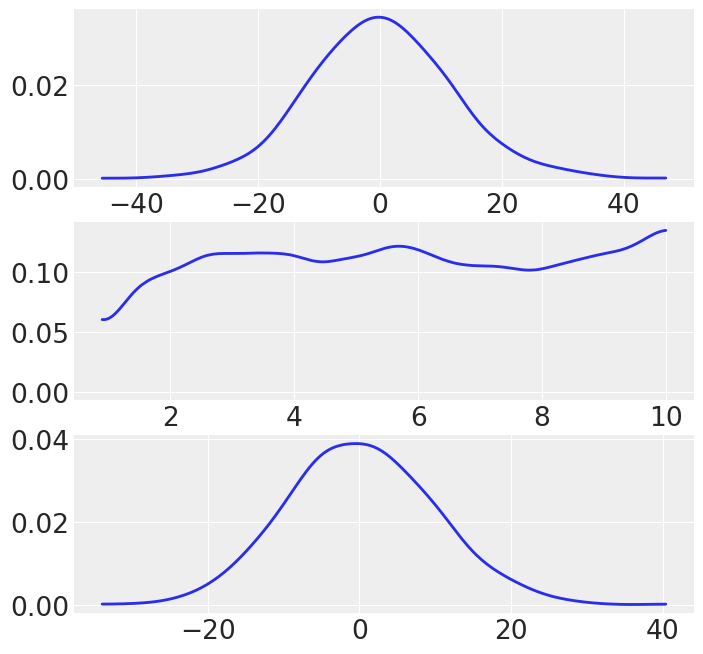

In [50]:
fig,ax = plt.subplots(3, figsize = (8,8))
az.plot_kde(trace_m41['y'], ax = ax[0])
az.plot_kde(trace_m41['sigma'], ax = ax[1])
az.plot_kde(trace_m41['mu'], ax = ax[2])

Compare with sampling manually:

In [26]:
sample_mu = stats.norm.rvs(0,10,1000)

In [27]:
sample_sigma = stats.uniform.rvs(0,10,1000)

In [28]:
sample_y = stats.norm.rvs(sample_mu,sample_sigma)

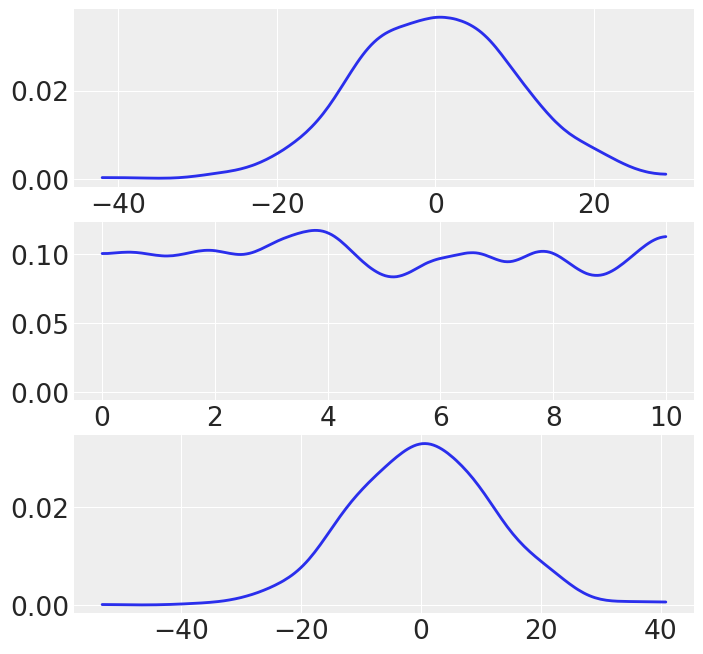

In [51]:
fig,ax = plt.subplots(3,figsize = (8,8))
az.plot_kde(sample_mu, ax = ax[0])
az.plot_kde(sample_sigma, ax = ax[1])
az.plot_kde(sample_y, ax = ax[2])

In [34]:
pm.stats.hpd(sample_y,0.11)

array([-18.00154287,  18.27252082])

In [35]:
pm.stats.hpd(trace_m41['y'],0.11)

array([-17.5069507 ,  18.77764553])

### 4M4

Linear model for heights:

$$ h_i \sim N( \mu_i, \sigma) $$
$$ \mu_i = \alpha + \beta x_i $$
$$ \alpha \sim N(100,20) $$
$$ \beta \sim N(0,10) $$
$$ \sigma \sim U(0,50)$$

### 4M5

Average height is 120 cm $ \rightarrow $ change mean of $\alpha$ to 120: $ \alpha \sim N(120,20) $

$ \beta $ is always positive $ \rightarrow $ change to lognormal distribution: $ \beta = logN(0,1) $

### 4M6

Since the variance of the height of students is never over 64, the standard deviation is never over 8.
Therefore we can limit the parameter sigma to the range:
$$ \sigma \sim U(0,8)  $$

### 4H1

In [91]:
df = pd.read_csv('../resources/Rethinking/Data/Howell1.csv', sep=';')

In [92]:
df.head(3)

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0


model:

$$ h_1 \sim N(\mu, \sigma) $$
$$ \mu = \alpha_0 + \alpha_1 w_i + \alpha_2 w_i^{2} $$
$$ \alpha_0 \sim N(178,20) $$
$$ \alpha_1 \sim logN(0,1) $$
$$ \alpha_2 \sim N(0,1) $$
$$ \sigma \sim U(0,50) $$

In [97]:
df['weight_s'] = (df['weight']-df['weight'].mean())/df['weight'].std()
df['weight_s2'] = df['weight_s']**2

In [120]:
with pm.Model() as h41_m:
    alpha_0 = pm.Normal('alpha_0', 178,20)
    alpha_1 = pm.Lognormal('alpha_1', 0 , 1)
    alpha_2 = pm.Normal('alpha_2', 0, 1)
    sigma = pm.Uniform('sigma', lower=0, upper = 50)
    mu = pm.Deterministic('mu', alpha_0 + alpha_1*df['weight_s'] + alpha_2*df['weight_s2'])
    h = pm.Normal('height', mu = mu, sd = sigma, observed = df['height'])
    trace_h41 = pm.sample(1000, tune= 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha_2, alpha_1, alpha_0]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1399.08draws/s]


In [121]:
mu_pred = h41_trace['mu']
height_pred = pm.sample_posterior_predictive(h41_trace, 300, h41_m)

100%|██████████| 300/300 [00:00<00:00, 2117.81it/s]


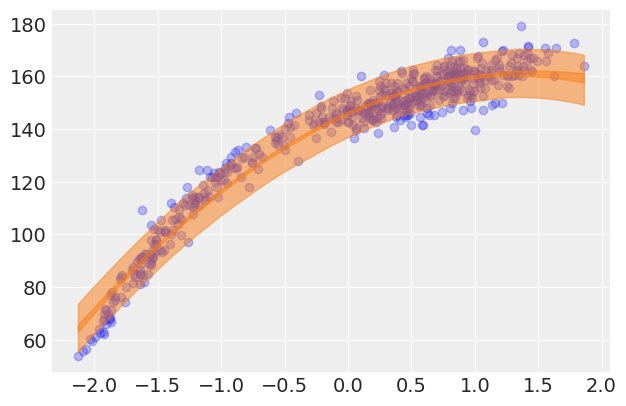

In [122]:
plt.scatter(df.weight_s, df.height, c='C0', alpha=0.3)
az.plot_hpd(df.weight_s, mu_pred, credible_interval=.89)
az.plot_hpd(df.weight_s, height_pred['height'], credible_interval=.89)

In [316]:
q_weights = pd.DataFrame()

In [317]:
q_weights['weight']=[46.95, 43.72, 64.78, 32.59, 54.63]

In [318]:
q_weights['weight_s'] = (q_weights['weight'] - df['weight'].mean())/df['weight'].std()

In [319]:
alpha_0_m = trace_h41['alpha_0'].mean()
alpha_1_m = trace_h41['alpha_1'].mean()
alpha_2_m = trace_h41['alpha_2'].mean()

In [320]:
q_weights['predicted height'] = alpha_0_m + alpha_1_m * q_weights['weight_s'] + alpha_2_m * q_weights['weight_s']**2

In [321]:
q_weights.head()

,weight,weight_s,predicted height
0,46.95,0.770381,158.167067
1,43.72,0.550940,155.660364
2,64.78,1.981726,158.481657
3,32.59,-0.205216,141.266938
4,54.63,1.292150,161.109825


In [322]:
q_weights = q_weights.sort_values('weight').reset_index(drop=True)

In [323]:
q_weights.head()

,weight,weight_s,predicted height
0,32.59,-0.205216,141.266938
1,43.72,0.550940,155.660364
2,46.95,0.770381,158.167067
3,54.63,1.292150,161.109825
4,64.78,1.981726,158.481657


Let's visualize the distributions at these locations using raincloudplots:

In [324]:
import ptitprince as pt
import seaborn as sns
import os
#sns.set(style="darkgrid")
#sns.set(style="whitegrid")
#sns.set_style("white")
sns.set(style="whitegrid",font_scale=2)
import matplotlib.collections as clt

In [390]:
results = pd.DataFrame()

In [391]:
a = ['32.59', '43.72', '46.95', '54.63', '64.78']

In [392]:
for i in a:
    results[i] = trace_h41['alpha_0'] + trace_h41['alpha_1'] * q_weights['weight_s'][a.index(i)]+ trace_h41['alpha_2'] * q_weights['weight_s'][a.index(i)]**2

In [393]:
results.head()

,32.59,43.72,46.95,54.63,64.78
0,141.831986,155.986257,158.350235,160.821187,157.283394
1,141.804993,156.159407,158.563098,161.095286,157.566745
2,141.812119,156.084470,158.492631,161.086544,157.749941
3,140.981870,155.593048,158.256793,161.742488,160.198049
4,141.736957,155.916565,158.300865,160.843562,157.451189


In [394]:
a = pd.DataFrame()

In [395]:
for column in results:
    a[column] = pm.stats.hpd(results[column],0.11)

In [396]:
a = a.T

In [397]:
a

,0,1
32.59,140.654385,141.883626
43.72,155.157123,156.120222
46.95,157.700885,158.700221
54.63,160.249654,162.014348
64.78,156.650854,160.559646


In [404]:
a = a.reset_index()

In [406]:
a.columns=['weight', 'lower CI 0.89', 'upper CI 0.89']

In [409]:
a

,weight,lower CI 0.89,upper CI 0.89
0,32.59,140.654385,141.883626
1,43.72,155.157123,156.120222
2,46.95,157.700885,158.700221
3,54.63,160.249654,162.014348
4,64.78,156.650854,160.559646


In [413]:
q_weights

,weight,weight_s,predicted height
0,32.59,-0.205216,141.266938
1,43.72,0.550940,155.660364
2,46.95,0.770381,158.167067
3,54.63,1.292150,161.109825
4,64.78,1.981726,158.481657


In [416]:
pd.concat([a,q_weights], axis = 1)

,weight,lower CI 0.89,upper CI 0.89,weight,weight_s,predicted height
0,32.59,140.654385,141.883626,32.59,-0.205216,141.266938
1,43.72,155.157123,156.120222,43.72,0.550940,155.660364
2,46.95,157.700885,158.700221,46.95,0.770381,158.167067
3,54.63,160.249654,162.014348,54.63,1.292150,161.109825
4,64.78,156.650854,160.559646,64.78,1.981726,158.481657


In [329]:
stack_results = results.stack().to_frame().reset_index()

In [332]:
stack_results.columns = ['nope','weight','predicted height']

In [333]:
stack_results.head()

,nope,weight,predicted height
0,0,32.59,141.831986
1,0,43.72,155.986257
2,0,46.95,158.350235
3,0,54.63,160.821187
4,0,64.78,157.283394


Text(0.5, 1.0, 'Figure P7\n Using the pt.Raincloud function')

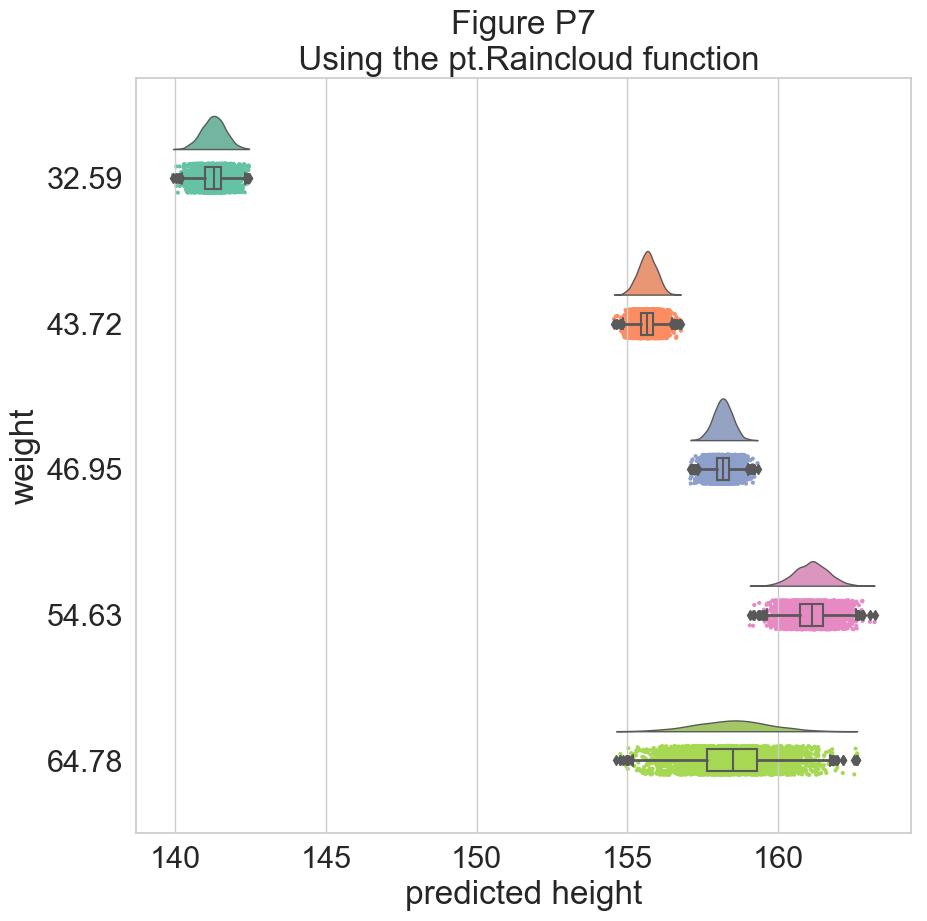

In [417]:
#same thing with a single command: now x **must** be the categorical value
dx = "weight"; dy = "predicted height"; ort = "h"; pal = "Set2"; sigma = .2
ax=pt.RainCloud(x = dx, y = dy, data = stack_results, palette = pal, bw = sigma,
                 width_viol = .6, figsize = (10,10), orient = ort)

plt.title("Figure P7\n Using the pt.Raincloud function")

### 4H2

Analysis of data with under 18 year old weight and height

In [3]:
df = pd.read_csv('../resources/Rethinking/Data/Howell1.csv', sep = ';')

In [4]:
child_df = df[df['age'] < 18]

In [5]:
child_df['weight_s'] = (child_df.weight-child_df.weight.mean())/child_df.weight.std()

C:\Users\Mikko\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
child_df.head(3)

,height,weight,age,male,weight_s
18,121.92,19.617854,12.0,1,0.134648
19,105.41,13.947954,8.0,0,-0.499618
20,86.36,10.489315,6.5,0,-0.886520


In [7]:
len(child_df)

192

$$ h_i \sim N(\mu_i, \sigma) $$
$$ \mu = \alpha_0 + \alpha_1 w_i $$
$$ \alpha_0 \sim N(120,20) $$
$$ \alpha_1 \sim N(2,5) $$
$$ \sigma \sim U(0,40) $$

In [8]:
with pm.Model() as model_4h2:
    sigma = pm.Uniform('sigma', lower=0, upper = 40)
    alpha_0 = pm.Normal('alpha_0', 120,20)
    alpha_1 = pm.Normal('alpha_1', 2,5)
    mu = pm.Deterministic('mu', alpha_0+alpha_1*child_df.weight_s)
    h = pm.Normal('height', mu = mu, sd = sigma, observed = child_df.height)
    trace_4h2 = pm.sample(1000, tune = 1000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_1, alpha_0, sigma]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:04<00:00, 1699.27draws/s]


In [19]:
mu_pred = trace_4h2['mu']
height_pred = pm.sample_posterior_predictive(trace_4h2, 200, model_4h2)

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1823.02it/s]


In [24]:
map_estimate = pm.find_MAP(model = model_4h2)

logp = -702.03, ||grad|| = 1.5213: 100%|█████████████████████████████████████████████| 30/30 [00:00<00:00, 3016.91it/s]


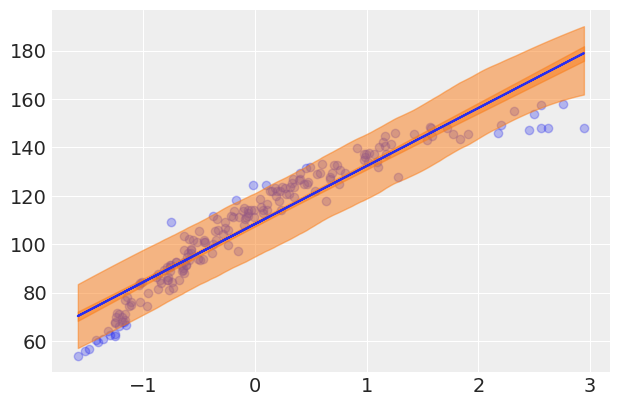

In [25]:
plt.scatter(child_df.weight_s,child_df.height, c = 'C0', alpha = 0.3)
az.plot_hpd(child_df.weight_s, mu_pred, credible_interval=0.89)
az.plot_hpd(child_df.weight_s, height_pred['height'], credible_interval=0.89)
plt.plot(child_df.weight_s, map_estimate['alpha_0'] + map_estimate['alpha_1'] * child_df.weight_s)

In [27]:
az.summary(trace_4h2['alpha_1'])

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,23.982,0.616,22.852,25.155,0.007,0.005,7077.0,7077.0,7106.0,3027.0,NaN


For every 1 unit of standardized weight, height is increased by 24 units

The model is linear, and thus only works on the linear part of the graph. The model may be improved by changing it into a higher order model.

### 4H3

New model with log of height scaling with weight

$$ y_i \sim N(\mu_i, \sigma) $$
$$ \mu_i = \alpha_0 + \alpha_1 log(w_i) $$
$$ \alpha_0 \sim N(178,20) $$
$$ \alpha_1 \sim N(0,100) $$
$$ \sigma \sim U(0,50) $$

In [31]:
with pm.Model() as model_4h3:
    alpha_0 = pm.Normal('alpha_0', 178,20)
    alpha_1 = pm.Normal('alpha_1', 0, 100)
    sigma = pm.Uniform('sigma', lower= 0, upper =50)
    mu = pm.Deterministic('mu', alpha_0 + alpha_1 * np.log(df.weight))
    height = pm.Normal('height', mu=mu, sd = sigma, observed=df.height)
    trace_4h3 = pm.sample(1000, tune= 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha_1, alpha_0]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 8000/8000 [00:08<00:00, 971.23draws/s]
The acceptance probability does not match the target. It is 0.8907983126338106, but should be close to 0.8. Try to increase the number of tuning steps.


In [40]:
pred_mu = trace_4h3['mu']
pred_height = pm.sample_posterior_predictive(trace = trace_4h3, model = model_4h3)

100%|████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:01<00:00, 2800.76it/s]


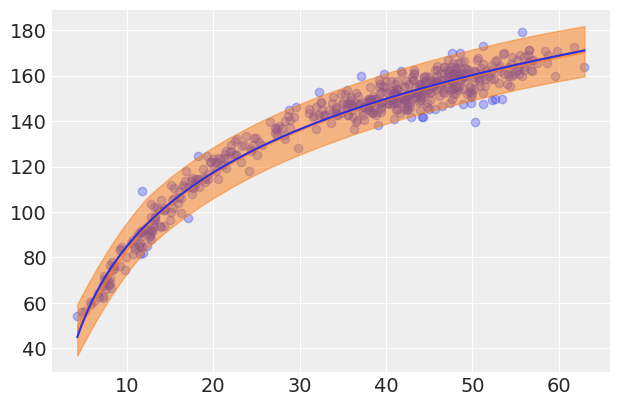

In [49]:
plt.scatter(df.weight,df.height, alpha = 0.3)
az.plot_hpd(df.weight, pred_mu, credible_interval=0.97)
az.plot_hpd(df.weight, pred_height['height'], credible_interval = 0.97)
plt.plot(df.sort_values(by='weight').weight, trace_4h3['alpha_0'].mean() + trace_4h3['alpha_1'].mean() * np.log(df.sort_values(by='weight').weight))